Future changes:  predicted melt data plots
===

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}

from netCDF4 import Dataset

import numpy    as np
import numpy.ma as ma
np.seterr(divide='ignore', invalid='ignore')

import matplotlib         as mpl
import matplotlib.pyplot  as plt
import matplotlib.colors  as colors
from   matplotlib.patches import Polygon

from mpl_toolkits.basemap    import Basemap, addcyclic, shiftgrid, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import math
import scipy.stats as ss

import pandas as pd
pd.options.mode.chained_assignment = None

from model import Model
from plotUtils import PlotUtils

%load_ext autoreload
%autoreload 2

Spatial bounds
---

In [2]:
minLon = -70 + 360
maxLon = -15 + 360
minLat = 58
maxLat = 86.5

midLat = (minLat + maxLat) / 2
midLon = (minLon  +maxLon) / 2

print "Latitudes", minLat,minLat,maxLat
print "Longitudes", minLon,midLon,maxLon

Latitudes 58 58 86.5
Longitudes 290 317 345


Function: Load data
---

In [3]:
def loadData( model, branch, ens, mon, suff, predVar = "tas" ):
    if branch == "historical":
        yr1 = "1996"
        yr2 = "2005"

    if branch in ( "rcp85", "1pt5degC"):
        yr1 = "2071"
        yr2 = "2080"

    try:
        mms = "%02d" % mon
    except:
        mms = mon

    if model == "cesmlw":
#         enss = "011"
        enss = "ens"
    else:
        try:
            enss = "%03d" % ens
        except:
            enss = ens

    yrs = yr1+"-"+yr2
    
    modelDataDir = "/Users/dbr/Documents/gismelt/models_vs_obs/gis_%s" % model
    readVar = "melt"
    if "cesm" in model:
        if suff is None:
            modelDataFN = "wrf_%s_%s_%s_newmelt_%s_%s.nc" % ( model, enss, predVar, yrs, mms )
        else:
            modelDataFN = "wrf_%s_%s_%s_newmelt_%s_%s_adj.nc" % ( model, enss, predVar, yrs, mms )
    else:
        modelDataFN = "wrf_%s_%s_newmelt_%s_%s.nc" % ( model, predVar, yrs, mms )
    
    if model == "melt":
        modelDataDir = "/Users/dbr/Documents/gismelt/mote_sfc_melt"
        modelDataFN = "Mote_%s_%s.nc" % ( yrs, mms )
        readVar = "greenland_surface_melt"
    
    print modelDataFN
    D = Model(None, modelDataDir+"/"+modelDataFN)
    X = np.array( D.loadData( readVar ) )
    
    if model == "melt":
        Xf = X.astype(float)
        id = ( X < 0 )
#         Xf[id] = np.nan
        Xf[id] = 0
        X = Xf

    return X.astype(float), yrs, mms

Function: Create title
---

In [4]:
def createTitle( model, branch, mms, caption = True ):
    months = dict( [ \
                      ( 'JJA', "JJA" ), \
                      ( '06', "Jun" ), \
                      ( '07', "Jul" ), \
                      ( '08', "Aug" ), \
                   ] )
    
    branches = dict( [ \
                      ( 'historical', "Historical" ), \
                      ( 'rcp85', "RCP 8.5" ), \
                      ( '1pt5degC', "1.5 $^\circ$C" ), \
                   ] )
    
    if model == "melt":
        modelStr = "Observations"
    else:
        modelStr = model.upper()

    try:
        monStr = months[mms]
    except:
        monStr = mms
    try:
        branchStr = branches[branch]
    except:
        branchStr = branch
    
    if caption:
        newLine = "\n"
    else:
        newLine = " "
    
#     titleStr = modelStr+" "+branchStr+" "+monStr
    if model == "melt":
        fmt = "{:s}{:}{:s} {:s}"
    else:
        if caption:
            fmt = "WRF({:s}){:}{:s} {:s}"
        else:
            fmt = "{:s}{:}{:s} {:s}"
    titleStr = fmt.format(modelStr, newLine, branchStr, monStr)
    
    return titleStr

Function: create colorbar
---

In [5]:
def createColorBar( fig, cs, cbtitle, axes, loc = 'bottom', format = None, fontSize = 18, cbdy = 0.0 ):
    cbShrink = 0.75
    xShrink = (1-cbShrink)/2
    
    if type(axes) is np.ndarray:
        axesL = axes.ravel().tolist()  # make numpy array into a list
    else:
        axesL = (axes,)  # make it a list
        
    if format is None:
        cbar = fig.colorbar(cs, location=loc,  ax=axesL, \
                            shrink = cbShrink);
    else:
        cbar = fig.colorbar(cs, location=loc,  ax=axesL, \
                            shrink = cbShrink, format=format);
    
    cbar.ax.set_xlabel(cbtitle, fontsize=fontSize)

    pos1 = cbar.ax.get_position()
    pos2 = [0.1, pos1.y0+cbdy, 0.8, pos1.y1+cbdy]
    cbar.ax.set_position( pos2 )
    
    imaxes = plt.gca()
    plt.sca(cbar.ax)
    plt.xticks(fontsize=fontSize)
    plt.sca(imaxes)
    
    return cbar

Class: "Normalize" function to center a colorbar on a specific value
---

In [6]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

Function: Create custom colormap
---

In [7]:
def customColormap( totSeg, stdCmap, mono = False ):
    if not mono:  # use a normal colormap
        if totSeg is None:  # not really customizing, just return standard colormap
            exec( "myCmap = mpl.cm."+stdCmap+"(np.arange(256))")
        else:
            # create a colormap with two parts:
            # - 1/totSeg          : custom colormap, ranging from white to the first color of the colormap
            # - (totSeg-1)/totSeg : existing colormap
            nCustSeg = 1                 # number of custom segments
            nStdSeg = totSeg - nCustSeg  # number of segments assigned to std colormap

            # set upper part: nStdSeg * 256/4 entries
            exec( "upper = mpl.cm."+stdCmap+"(np.arange(256))")
            # upper = mpl.cm.cool(np.arange(256))
            # upper = mpl.cm.YlOrRd(np.arange(256))

            # set lower part: 1 * 256/4 entries
            # - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
            lower = np.ones((int(256/nStdSeg),4))

            # - modify the first three columns (RGB):
            #   range linearly between white (1,1,1) and the first color of the upper colormap
            for i in range(3):
              lower[:,i] = np.linspace(1, upper[0,i], lower.shape[0])

            # combine parts of colormap
            myCmap = np.vstack(( lower, upper ))
    else:  # use a single color map
        rgbColor = colors.to_rgba(stdCmap)
        myCmap = np.ones((256,4)) * rgbColor
#         exec( "myCmap = mpl.cm."+stdCmap+"(np.arange(256))")
#         myCmap[0:-1,:] = myCmap[-1,:]

    # convert to matplotlib colormap
    myCmap = mpl.colors.ListedColormap(myCmap, name='myColorMap', N=myCmap.shape[0])
    
    return myCmap

Global data
---

In [8]:
gFile = "wrf_geog.nc"
G = Model( None, gFile )
lat = np.array( G.loadData( "lat" ) )
nLat = len(lat)
lon = np.array( G.loadData( "lon" ) )
nLon = len(lon)

doCN = 1  # add single contour?
cnSuff = "_cn"

# mon = 6
# mon = 7
# mon = 8
mon = "JJA"

ens = "ens"
# ens = 1

cutoff = None

levels = 60

# specify contour levels explicitly
# levels = np.arange( -480, 960, 160 )
# levels = np.arange( -450, 0, 50 )

figW = 9
figH = 8

Setup plotting
---

In [14]:
plotStr = "agu19melt"
plotOptions = { "saveFigure": False }
# plotOptions = { "saveFigure": True }

P = PlotUtils( plotOptions )

Load Mote ice sheet mask
---

In [10]:
fn = "icesheet_mask.nc"
ncfn = Dataset(fn, "r")
icemask2d = np.array( ncfn.variables[ "icemask" ] )

nIcePoints = np.nansum( icemask2d )
print str(nIcePoints)+" ice sheet points"

7799 ice sheet points


Load data
---

In [11]:
predVar = "tas"
# predVar = "tasmax"

models = ( "melt", "erai", "cesmle", "cesmle", "cesmlw" )
branches = ( "historical", "historical", "historical", "rcp85", "1pt5degC" )
# models = ( "melt", "erai" )
# branches = ( "historical", "historical" )

index = 0
for model, branch in zip( models, branches ):
    M, yrs, mms = loadData( model, branch, ens, mon, "adj", predVar )
    nRec, nLat, nLon = M.shape
    if index == 0:
        melt = np.zeros( [len(models), nRec, nLat, nLon] )
        meltSum = np.zeros( [len(models), nLat, nLon] )
        icemask3d = np.repeat( icemask2d[None,:,:],nRec,axis=0)
        noice = (icemask3d < 1)
    np.nan_to_num( M, False )    
    nodata = (M < 0)
    M[nodata] = 0
    M[noice] = np.nan

    melt[index,:,:,:] = M
    meltSum[index,:,:] = np.sum( M, axis = 0 )
   
    index += 1

# issues with "_FillValue" mean there are some VERY large negative values in meltSum,
# so let's change those to nan.
# nodata = (meltSum < 0)
# meltSum[nodata] = np.nan

# calculate melt fraction
meltFrac = meltSum / nRec * 100.

# ...and how many models were there?
nModels = meltSum.shape[0]

Mote_1996-2005_JJA.nc
wrf_erai_tas_newmelt_1996-2005_JJA.nc
wrf_cesmle_ens_tas_newmelt_1996-2005_JJA_adj.nc
wrf_cesmle_ens_tas_newmelt_2071-2080_JJA_adj.nc
wrf_cesmlw_ens_tas_newmelt_2071-2080_JJA_adj.nc


Calculate daily melt area fraction, all datasets
---

In [12]:
# mID = 0
# print str(nIcePoints)+" ice sheet points"
meltCnt = np.zeros( (nRec,nModels) )
for index in range( nModels ):
    for day in range( 0,nRec ):
        meltSub = melt[index,day,:,:]
        meltID = (meltSub > 0)
        meltLoc = np.zeros( icemask2d.shape )
        meltLoc[meltID] = 1
        meltCnt[day,index] = np.nansum(meltLoc)
meltCntF = meltCnt / nIcePoints

Make boxplots for daily data (Saved as PDF for transparency usage)
---

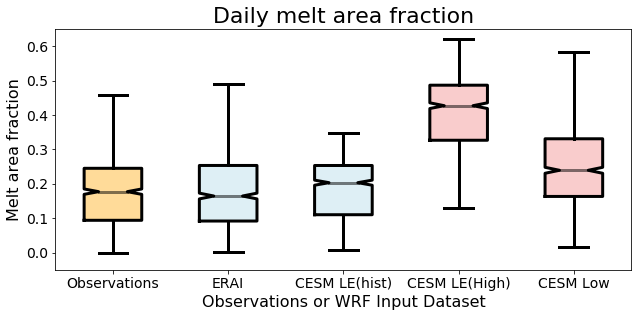

In [13]:
xlabels = ['Observations','ERAI','CESM LE(hist)','CESM LE(High)','CESM Low']
fig, ax = plt.subplots(figsize=(10,5))

cap_props     = dict(linewidth=3)  # cap properties
box_props     = dict(linewidth=3)  # box properties
whisker_props = dict(linewidth=3)  # whisker properties
# flier_props   = dict(markeredgecolor="darkviolet", marker="o", markersize=6) # outlier marker properties
flier_props   = dict(markeredgecolor="darkviolet", marker="", markersize=6) # outlier marker properties
median_props  = dict(linewidth=3, color="k", alpha=0.5)  # median line properties
# median_props  = None

# whisker options
# 'range' - full data range, no "fliers"
# float (default 1.5) - multiplier of IQR
# percentile spec, e.g., [5,95]
# None (uses default)
bp = ax.boxplot( meltCntF, notch = True, whis = None,
                 whiskerprops = whisker_props, boxprops = box_props,
                 flierprops = flier_props, medianprops = median_props, capprops = cap_props )

ax.set_title('Daily melt area fraction',fontsize=22)
# ax.set_xlabel('Dataset',fontsize=16)
ax.set_xlabel('Observations or WRF Input Dataset',fontsize=16)
ax.set_ylabel('Melt area fraction',fontsize=16)
ax.set_ylim( -0.05, 0.65)
ax.set_xticklabels( xlabels,rotation=0,fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.tight_layout( rect = (0.05, 0.05, 0.95, 0.95) )    

# color the boxes
box_colors = ['orange', 'lightblue', 'lightblue', 'lightcoral', 'lightcoral']
num_boxes = meltCntF.shape[1]
medians = np.empty(num_boxes)
for i in range(num_boxes):
    box = bp['boxes'][i]
    boxX = []
    boxY = []
    for j in range(10):
        boxX.append(box.get_xdata()[j])
        boxY.append(box.get_ydata()[j])
    box_coords = np.column_stack([boxX, boxY])

    # Add patches
    ax.add_patch(Polygon(box_coords, facecolor=box_colors[i], alpha=0.4) )

# --- Don't seem to need this (from the internet example)
#     # Now draw the median lines back over what we just filled in
#     med = bp['medians'][i]
#     medianX = []
#     medianY = []
#     for j in range(2):
#         medianX.append(med.get_xdata()[j])
#         medianY.append(med.get_ydata()[j])
#         ax.plot(medianX, medianY, 'blue')
#     medians[i] = medianY[0]
  
# --- Just going to skip adding the symbol for the mean value to simplify
#     # Finally, overplot the sample averages, with horizontal alignment
#     # in the center of each box
#     med = bp['medians'][i]
#     ax.plot(np.average(med.get_xdata()), np.average(meltCntF[:,i]),
#             color='k', marker='*', markeredgecolor='k', markersize=10,
#             zorder=10)

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac_boxplot", fmt="pdf" )

In [14]:
# print str(nIcePoints)+" ice sheet points"
# nMeltLoc = np.zeros( ( nModels) )
# for index in range( nModels ):
#     meltID = (meltSum[index,:,:] > 0)
#     meltLoc = np.zeros( icemask2d.shape )
#     meltLoc[meltID] = 1
#     nMeltLoc[index] = np.nansum(meltLoc)
# print nMeltLoc

Total melt days per scenario
---

In [14]:
for index in range( nModels ):
    title = createTitle( models[index], branches[index], mms, False )
    meltCount = int(np.nansum( meltSum[index,:,:] ))
    if index == 0:
        meltBase = meltCount
        print "{:25} {:,d}".format( title, meltCount )
    else:
        diffCnt = meltCount - meltBase
        diffPct = float(diffCnt) / meltBase * 100.
        print "{:25} {:,d} {:9,d} {:6.1f}".format( title, meltCount, diffCnt, diffPct )

Observations Historical JJA 1,314,627
ERAI Historical JJA       1,318,603     3,976    0.3
CESMLE Historical JJA     1,319,183     4,556    0.3
CESMLE RCP 8.5 JJA        2,900,588 1,585,961  120.6
CESMLW 1.5 $^\circ$C JJA  1,850,010   535,383   40.7


Obs + Future: Melt sum
===

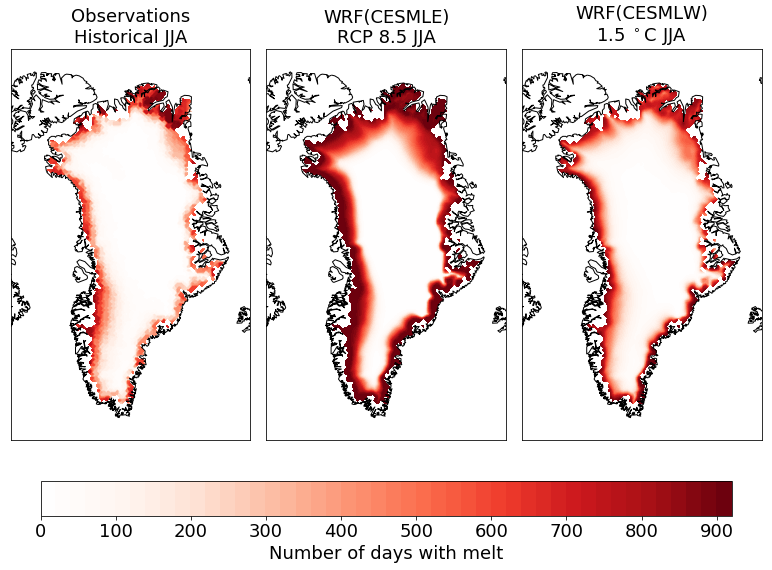

In [15]:
doCN = 0  # add single contour?
cLev2 = 230
mdlIndex = (0,3,4)
meltSum2 = meltSum[mdlIndex,:,:]
meltFrac2 = meltFrac[mdlIndex,:,:]
nModels = meltSum2.shape[0]

fig, axes = plt.subplots(nrows=1, ncols=nModels, figsize=(4*nModels,3*nModels))
axesF = axes.flat

# cLev = np.linspace( 0, nRec, 20 )
cLev = np.arange( 0, nRec+1, 20 )
myCmap = customColormap( 8, "Reds")
for index in range( nModels ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    cs = m.contourf(x, y, meltSum[mdlIndex[index],:,:], cLev, cmap = myCmap)
    if doCN:
        cn = m.contour(x, y, meltSum[mdlIndex[index],:,:], levels = [cLev2], linewidths=2, colors='k')
    axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=18);

# plt.tight_layout( w_pad=0.01, h_pad=0.01 )    
plt.tight_layout( rect = (0.05, 0.05, 0.95, 0.95) )    

cbar = createColorBar( fig, cs, 'Number of days with melt', axes )
cbar.set_ticks( np.arange(0, 921, 100))

# NOT doing print setup for this since I do that in plot_wrf_tas_newmelt.ipynb

Future : Melt days : Differences versus observations
---

Saving figure to wrf_agu19melt_tas_meltSum_future_diff.eps


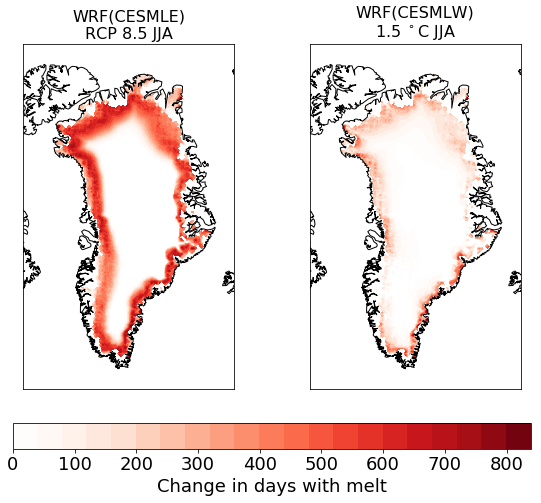

In [12]:
nModels = 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(figW,figH))
axesF = axes.flat
refMelt = meltSum[0,:,:]
mdlIndex = (3,4)
dMelt = np.zeros( [nModels, meltSum[0].shape[0], meltSum[0].shape[1] ])

# cLev = np.linspace( 0, nRec, 20 )
# cLev = np.arange( 0, nRec, 20 )
cLev = np.arange( 0, nRec+1, 20 )
# myCmap = customColormap( 8, "coolwarm")
myCmap = customColormap( 10, "Reds")
for index in range( nModels ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    diffM = meltSum[mdlIndex[index],:,:] - refMelt
    nodata = (diffM < 10)
    diffM[nodata] = np.nan
    dMelt[index,:,:] = diffM

#     cs = m.contourf(x, y, dMelt, 20, cmap = myCmap, norm=MidpointNormalize(midpoint=0.))
    cs = m.contourf(x, y, dMelt[index,:,:], 20, cmap = myCmap)

#     if doCN:
#         cn = m.contour(x, y, meltSum[mdlIndex[index],:,:], levels = [cLev2], linewidths=2, colors='k')
#     axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=18);
    axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=16);

# plt.tight_layout( w_pad=0.01, h_pad=0.01 )    
plt.tight_layout( rect = (0.05, 0.05, 0.95, 0.95) )    

cbar = createColorBar( fig, cs, 'Change in days with melt', axes )
cbar.set_ticks( np.arange(0, 901, 100))

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltSum_future_diff" )

Standardized version
---
This was intended to be similar to the standardized version of (model-obs) but it just doesn't seem to have any real value.

In [15]:
# # create standardized version
# dMeltMsk = ma.masked_invalid( dMelt )
# dMeltZ = np.zeros( [nModels, meltSum[0].shape[0], meltSum[0].shape[1] ])
# for ix in (0,1):
#     dMeltZ[ix,:,:] = ss.zscore(dMeltMsk[ix,:,:])
# dMeltZ = dMeltZ - np.nanmin(dMeltZ)

# fig, axes = plt.subplots(nrows=1, ncols=nModels, figsize=(figW,figH))
# if nModels < 2:
#     axes = np.array(axes)
# axesF = axes.flat

# for index in range( nModels ):
#     m = Basemap( projection='stere', width=1900000, height=3100000, \
#                  lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
#                  ax = axesF[index] )
#     if index == 0:
#         x, y = m( lon, lat )
#     m.drawcoastlines();
#     cs = m.contourf(x, y, dMeltZ[index,:,:], levels, cmap = plt.get_cmap("bwr"), \
#                 norm=MidpointNormalize(midpoint=0.))
#     axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=16);

# # plt.tight_layout( w_pad=0.01, h_pad=0.01 )    
# plt.tight_layout( rect = (0.05, 0.05, 0.95, 0.95) )    

# cbar = createColorBar( fig, cs, 'Future vs recent, standardized', axes )

# P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltSum_future_diffx2_Z" )

Obs + Future: Melt fraction
---

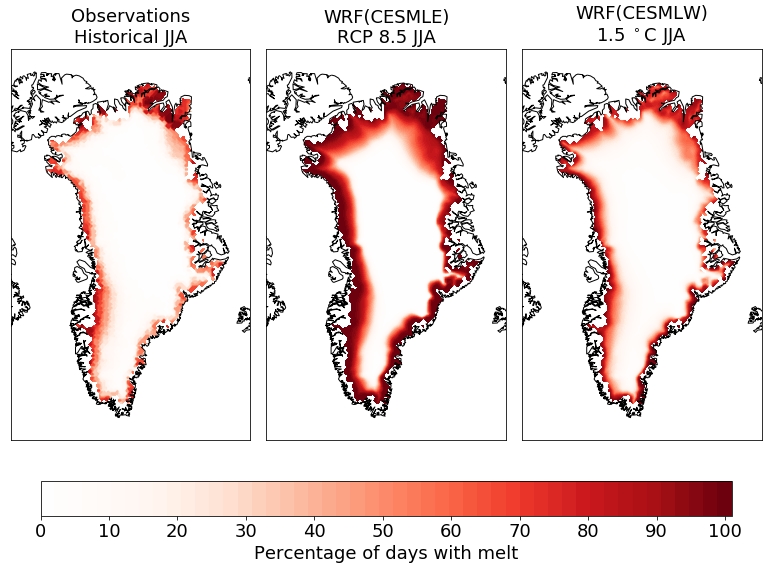

In [17]:
doCN = 0  # add single contour?
nModels = meltSum2.shape[0]
mdlIndex = (0,3,4)
cLev2 = 25.
fig, axes = plt.subplots(nrows=1, ncols=nModels, figsize=(4*nModels,3*nModels))
axesF = axes.flat

cLev = np.linspace( 0., 101. )
# myCmap = customColormap( None, "YlOrRd")
myCmap = customColormap( 6, "Reds")
# myCmap = customColormap( 5, "cool")
# myCmap = customColormap( 5, "spring")
for index in range(nModels):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    cs = m.contourf(x, y, meltFrac[mdlIndex[index],:,:], cLev, cmap = myCmap )
    if doCN:
        cn = m.contour(x, y, meltFrac[mdlIndex[index],:,:], levels = [cLev2], linewidths=2, colors='k')
    axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ), fontsize=18);

# plt.tight_layout( w_pad=0.01, h_pad=0.01 )    
plt.tight_layout( rect = (0.05, 0.05, 0.95, 0.95) )    

cbar = createColorBar( fig, cs, 'Percentage of days with melt', axes, 'bottom', "%0.0f" )
cbTickMarks = np.append( np.arange(0, 100, 10), 100)
cbar.set_ticks( cbTickMarks )

if doCN:
    P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac_future"+cnSuff )
else:
    P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac_future" )
    
# NOT doing print setup for this since I do that in plot_wrf_tas_newmelt.ipynb

Future: Melt fraction : Differences versus observations
---

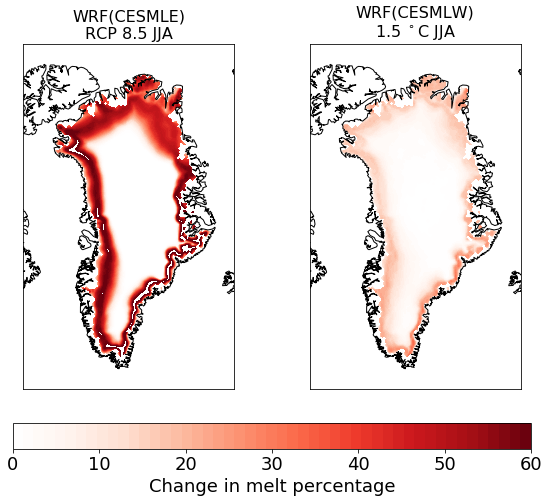

In [15]:
nModels = 2
mdlIndex = (3,4)
refMelt = meltFrac[1,:,:]
dMeltFrac = np.empty( [nModels, meltSum[0].shape[0], meltSum[0].shape[1] ])
dMeltFrac[0,:,:] = meltFrac[mdlIndex[0],:,:] - refMelt
dMeltFrac[1,:,:] = meltFrac[mdlIndex[1],:,:] - refMelt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(figW,figH))
axesF = axes.flat

cLev = np.linspace( 0., 60. )
myCmap = customColormap( 10, "Reds")
for index in range( nModels ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();

#     cs = m.contourf(x, y, dMelt, cLev, cmap = plt.get_cmap("coolwarm"), norm=MidpointNormalize(midpoint=0.))
    cs = m.contourf(x, y, dMeltFrac[index,:,:], cLev, cmap = myCmap)
    
#     if doCN:
#         cn = m.contour(x, y, meltSum[mdlIndex[index],:,:], levels = [cLev2], linewidths=2, colors='k')
#     axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=18);
    axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=16);

# plt.tight_layout( w_pad=0.01, h_pad=0.01 )    
plt.tight_layout( rect = (0.05, 0.05, 0.95, 0.95) )    

cbar = createColorBar( fig, cs, 'Change in melt percentage', axes )
cbTickMarks = np.append( np.arange(0, 60, 10), 60)
cbar.set_ticks( cbTickMarks )

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac_future_diff" )

Future : Melt Fraction : Show series of incremental differences: CESM LE RCP8.5
---

Saving figure to wrf_agu19melt_tas_meltFrac_future_diff_le_x4.eps


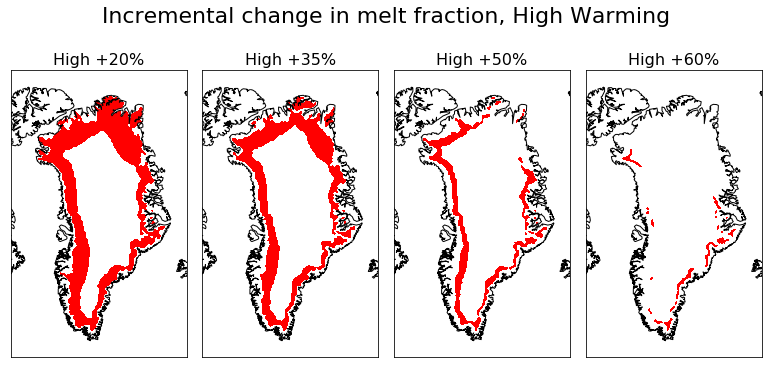

In [25]:
# threshList = ( 20., 30., 40., 50., 60. )
# threshList = ( 20., 30., 40., 50. )
threshList = ( 20., 35., 50., 60. )
nPlot = len(threshList)
fig, axes = plt.subplots(nrows=1, ncols=nPlot, figsize=(nPlot*3,6))
axesF = axes.flat

mdlIndex = (3,4)
refMelt = meltFrac[1,:,:]
r = 0
mdl = mdlIndex[r]
scenario = "High"

cLev = np.linspace( 0., 100., 11 )
index = 0
lowerThresh = 0.
myCmap = customColormap( 10, "red", True)
for thresh in threshList:
    tstr = "%.0f%%" % thresh
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();

    dMelt = np.copy(dMeltFrac[r,:,:])
    nodata = (dMelt < thresh)
    dMelt[nodata] = np.nan

    cs = m.contourf(x, y, dMelt, cLev, cmap = myCmap)
#     axesF[index].set_title( models[mdl]+" +"+tstr,  fontsize=16);
    axesF[index].set_title( scenario+" +"+tstr,  fontsize=16);
    index += 1
    lowerThresh = thresh

plt.suptitle('Incremental change in melt fraction, High Warming',fontsize=22)
    
# plt.tight_layout( w_pad=0.01, h_pad=0.01 )    
plt.tight_layout( rect = (0.05, 0.05, 0.95, 0.95) )    

# cbar = createColorBar( fig, cs, 'Change in melt fraction', axes )

# P.setOption( { "saveFigure": False } )
P.setOption( { "saveFigure": True } )
P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac_future_diff_le_x4" )

Future : Melt Fraction : Show series of incremental differences: CESM LW
---

Saving figure to wrf_agu19melt_tas_meltFrac_future_diff_lw1_x4.eps


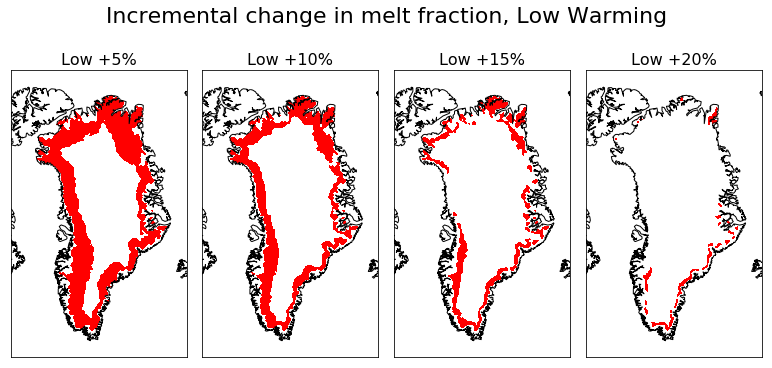

In [21]:
# threshList = ( 5., 10., 15., 20., 25. )
threshList = ( 5., 10., 15., 20. )
nPlot = len(threshList)

fig, axes = plt.subplots(nrows=1, ncols=nPlot, figsize=(nPlot*3,6))
axesF = axes.flat

refMelt = meltFrac[1,:,:]
mdlIndex = (3,4)
r = 1
mdl = mdlIndex[r]
scenario = "Low"

cLev = np.linspace( 0., 100., 11 )
index = 0
lowerThresh = 0.
myCmap = customColormap( 10, "red", True)
for thresh in threshList:
    tstr = "%.0f%%" % thresh
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();

    dMelt = np.copy(dMeltFrac[r,:,:])
#         nodata = (dMelt < lowerThresh)
#         dMelt[nodata] = np.nan
#         nodata = (dMelt > thresh)
#         dMelt[nodata] = np.nan
    nodata = (dMelt < thresh)
    dMelt[nodata] = np.nan

    cs = m.contourf(x, y, dMelt, cLev, cmap = myCmap)
    axesF[index].set_title( scenario+" +"+tstr,  fontsize=16);
    index += 1
    lowerThresh = thresh

plt.suptitle('Incremental change in melt fraction, Low Warming',fontsize=22)

# plt.tight_layout( w_pad=0.01, h_pad=0.01 )    
plt.tight_layout( rect = (0.05, 0.05, 0.95, 0.95) )    

# cbar = createColorBar( fig, cs, 'Change in melt fraction', axes )

# P.setOption( { "saveFigure": False } )
P.setOption( { "saveFigure": True } )
P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac_future_diff_lw1_x4" )

As above but use High Warming for last plot
---

Saving figure to wrf_agu19melt_tas_meltFrac_future_diff_lw2_x4.eps


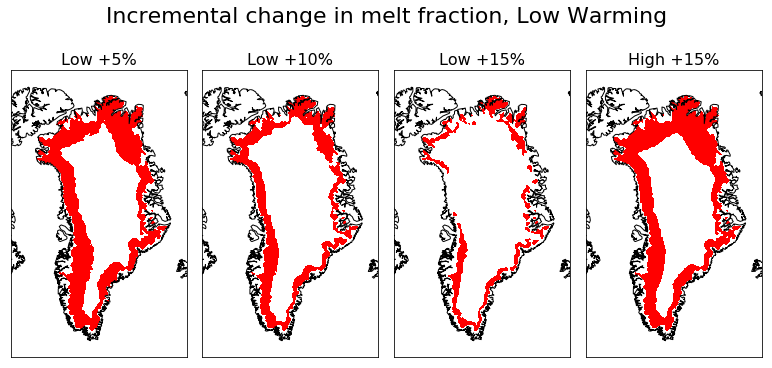

In [24]:
# threshList = ( 5., 10., 15., 20. )
# # threshList = ( 5., 10., 15. )
# nPlot = len(threshList)+1

# fig, axes = plt.subplots(nrows=1, ncols=nPlot, figsize=(nPlot*3,6))
# axesF = axes.flat

# # use Low for plots 1-4
# refMelt = meltFrac[1,:,:]
# mdlIndex = (3,4)
# r = 1
# mdl = mdlIndex[r]
# scenario = "Low"

# cLev = np.linspace( 0., 100., 11 )
# index = 0
# lowerThresh = 0.
# myCmap = customColormap( 10, "red", True)
# for thresh in threshList:
#     tstr = "%.0f%%" % thresh
#     m = Basemap( projection='stere', width=1900000, height=3100000, \
#                  lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
#                  ax = axesF[index] )
#     if index == 0:
#         x, y = m( lon, lat )
#     m.drawcoastlines();

#     dMelt = np.copy(dMeltFrac[r,:,:])

#     nodata = (dMelt < thresh)
#     dMelt[nodata] = np.nan

#     cs = m.contourf(x, y, dMelt, cLev, cmap = myCmap)
#     axesF[index].set_title( scenario+" +"+tstr,  fontsize=16);
#     index += 1
#     lowerThresh = thresh

# # use High for plot 5
# r = 0
# mdl = mdlIndex[r]
# scenario = "High"
# m = Basemap( projection='stere', width=1900000, height=3100000, \
#              lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
#              ax = axesF[index] )
# m.drawcoastlines();
# dMelt = np.copy(dMeltFrac[r,:,:])
# nodata = (dMelt < thresh)
# dMelt[nodata] = np.nan

# cs = m.contourf(x, y, dMelt, cLev, cmap = myCmap)
# axesF[index].set_title( scenario+" +"+tstr,  fontsize=16);

# # add titles, etc.
# plt.suptitle('Incremental change in melt fraction, Low Warming',fontsize=22)

# # plt.tight_layout( w_pad=0.01, h_pad=0.01 )    
# plt.tight_layout( rect = (0.05, 0.05, 0.95, 0.95) )    

# # cbar = createColorBar( fig, cs, 'Change in melt fraction', axes )

# P.setOption( { "saveFigure": False } )
# # P.setOption( { "saveFigure": True } )
# P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac_future_diff_lw2_x4" )